In [1]:
import numpy as np
import itertools
from scipy import optimize
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import csv
import json
import gzip
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
ssw = sys.stdout.write
ssf = sys.stdout.flush

#from IPython.display import clear_output
import seaborn as sns
import matplotlib
%matplotlib inline

homedir = os.path.expanduser('~/')
datadir = '../data/generated_files/'
res_dir = '../data/generated_files/'
fig_dir = '../figures/manuscript'

In [2]:
#sns.set(style="white")
#sns.set_context("paper")

def figsize(scale,ratio):
    fig_width_pt = 468.0                      # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'pdf.fonttype': 42,
                                              'ps.fonttype': 42,
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [3]:
figsize(1.6, "golden")

[10.361145703611458, 6.403540207221825]

In [4]:

def ccdf(z, no_duplicates=True, log_bins=-1):
    n = len(z)
    xx0 = np.sort(z)
    yy0 = 1. - 1.*np.array(range(n))/n

    if no_duplicates or log_bins>1:
        x2y = dict.fromkeys(set(xx0), 0.0)
        for x,y in list(zip(xx0,yy0)):
            x2y[x] = max(y,x2y[x])
        xx0,yy0 = list(zip(*sorted(x2y.items())))

    if log_bins>1:
        xxl = np.logspace(np.log10(min(z)),np.log10(max(z)),log_bins)
        yyl = []
        j = 0
        for xl in xxl[:]:
            while xx0[j]<xl and j<len(xx0)-1:
                j += 1
            yyl += [yy0[j]]
        return xxl,yyl
#         xxl = np.array(xxl)
#         yyl = np.array(yyl)
#         return (xxl[1:]+xxl[:-1])/2 , yyl #[1:]+yyl[:-1])/2

    return (xx0,yy0)


def bin_ccdf(x,y, nbins=100, scale='log', xmin='NaN', xmax='NaN', exclude_zeros=True):
    """
    Given a ccdf it returns a resampled ccdf at specific data points
    
    x,y  :  output of function `ccdf`
    
    """
    if xmin=='NaN':
        xmin = min(x)
    if xmax=='NaN':
        xmax = max(x)
    if scale=='log':
        xx = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
    elif scale=='lin':
        xx = np.linspace(xmin,xmax, nbins)
    else:
        xx = nbins
    n = len(y)-1
    def get_y(x,i,n):
        s = np.searchsorted(x, i)
        if s<n:
            return y[s]
        elif s==n:
            return y[-1]
        else:
            return 0.
    yy = [get_y(x,i,n) for i in xx]

    if exclude_zeros:
#        x0,y0 = list(map(list,zip(*[[xx[0],yy[0]]]+\
#                     [[xx[i],yy[i]] for i in range(len(yy)-1) if yy[i]!=yy[i+1]])) )
        x0,y0 = list(map(list,zip(*\
                   [[xx[i],yy[i]] for i in range(len(yy)-1) if yy[i]!=yy[i+1]])) )
        if yy[-1]>0.:
            x0 += [xx[-1]]
            y0 += [yy[-1]]
        return x0,y0
    else:
        return xx,yy

    
def combine_ccdfs(x_y_n0, x_y_n1, nbins=100, scale='log'):
    """
    Given two ccdfs, it returns the combined ccdf, 
    as if it were computed considering both data.
    
    x_y_n0  :  [x,y,n] with x and y being the output of function `ccdf` 
        and n the total number of data points (`len(z)`)
    x_y_n1  :  same format of x_y_n0
    
    """
    x0,y0,n0 = x_y_n0
    x1,y1,n1 = x_y_n1

    xmin = min(min(x0),min(x1))
    xmax = max(max(x0),max(x1))

    bx0,by0 = list(map( np.array,
        bin_ccdf(x0,y0, nbins=nbins, scale=scale, xmin=xmin, xmax=xmax, exclude_zeros=False) ))
    bx1,by1 = list(map( np.array,
        bin_ccdf(x1,y1, nbins=nbins, scale=scale, xmin=xmin, xmax=xmax, exclude_zeros=False) ))

    return bin_ccdf(bx0, (by0*n0 + by1*n1)/(n0+n1), nbins=nbins, scale=scale)


def sample_from_ccdf(x, y, samples=1):
    """
    x,y  :  arrays, x and y outputs of a ccdf (sorted)
    samples  :  int, number of samples to draw
    """
    n = len(x) - 1
    uniform_samples = np.random.random(samples)
    indexes = np.searchsorted(1. - np.array(y) , uniform_samples)
    return np.array([x[min(i,n)] for i in indexes])



def power_law_fit_ccdf(xxl, yyl, upper_cutoff='NA', lower_cutoff='NA', init_vals=[-1.,1.]):
    """
    
    Example
    -------
    
        # Fit  B * x ** A
        B,A,Aerr = power_law_fit_ccdf(xxl, yyl)
    
        plt.plot(xx, B * xx ** A, '-r', lw=3, alpha=0.5,\
                 label=r'$x^{%s \pm %s}$'%(np.round(A,2),np.round(Aerr,2)) )
        plt.plot(xx, B * xx **(A-Aerr), '--r', lw=2, alpha=0.5)
        plt.plot(xx, B * xx **(A+Aerr), '--r', lw=2, alpha=0.5)
    
    """
    n = len(xxl)

    if lower_cutoff == 'NA':
        lo_cut = 0
    else:
        lo_cut = min(n-1, np.searchsorted(xxl, lower_cutoff) )

    if upper_cutoff == 'NA':
        up_cut = n
    else:
        up_cut = min(n-1, np.searchsorted(xxl, upper_cutoff) )

    # Fit
    fitfunc = lambda x,a,b: np.log((x*b)**a)

    popt, pcov = curve_fit(fitfunc, \
                    xxl[lo_cut : up_cut], \
                    np.log(yyl[lo_cut : up_cut]), \
        p0=init_vals, maxfev=10000)

    perr = np.sqrt(np.diag(pcov)) * 1.
    
    return popt[1]**popt[0], popt[0], perr[0]


# 05x05

In [5]:
tilesize = '05x05'

## `macro2tileid2data`

In [6]:
macro2tileid2data = {}
macro_05x05 = []
macro2tileid = {}
tileid2macro = {}

with open(datadir+'macro_%s.csv'%tilesize,'r') as csv_file:
    f = csv.reader(csv_file, delimiter=',')
    next(f)
    for macro, tileid, urban_area_km2, num_urban, tile_km2 in f:
        macro_05x05 += [[macro, tileid, float(urban_area_km2), float(num_urban), float(tile_km2)]]
        
        try:
            tileid2data = macro2tileid2data[macro]
        except KeyError:
            macro2tileid2data[macro] = {}
            tileid2data = macro2tileid2data[macro]
            
        tileid2data[tileid] = [float(urban_area_km2), float(num_urban), float(tile_km2)]
        
        try:
            macro2tileid[macro] += [tileid]
        except KeyError:
            macro2tileid[macro]  = [tileid]
        try:
            tileid2macro[tileid] += [macro]
        except KeyError:        
            tileid2macro[tileid]  = [macro]
    

macro2max_tile_area = {macro: max([l[2] for tile,l in tileid2data.items()] ) \
    for macro,tileid2data in macro2tileid2data.items()}
    

df_05x05 = pd.DataFrame(macro_05x05, columns=\
                ['macro', 'tileid', 'urban_area_km2', 'num_urban', 'tile_km2'])

all_macros = pd.unique(df_05x05['macro'])

print(len(macro_05x05))
df_05x05[:5]

64949


,macro,tileid,urban_area_km2,num_urban,tile_km2
0,Australia N. Zealand,51310,0.0,0.0,2.966727
1,Australia N. Zealand,51311,0.0,0.0,44.534111
2,Australia N. Zealand,52019,0.0,0.0,8.557621
3,Australia N. Zealand,54136,0.0,0.0,54.172484
4,Australia N. Zealand,54137,0.0,0.0,183.413999


In [7]:
df_05x05.dtypes

macro              object
tileid             object
urban_area_km2    float64
num_urban         float64
tile_km2          float64
dtype: object

In [8]:
all_macros

array(['Australia N. Zealand', 'Central America', 'Central Asia',
       'Eastern Africa', 'Eastern Asia', 'Eastern Europe',
       'Middle Africa', 'North America', 'Northern Africa',
       'South America', 'Southeastern Asia', 'Southern Africa',
       'Southern Asia', 'Western Africa', 'Western Asia',
       'Western Europe'], dtype=object)

## Using rescaled tiles

### `tileid2data_rescaled4`

In [9]:
%%time

tileid2data_rescaled4 = {}

count = 1

with gzip.open(datadir+'filippo_areas_reduced4.csv.gz','rt') as csv_file:
    f = csv.reader(csv_file, delimiter=',')
    next(f)
    for tileid, area_km2 in f:
        count += 1
        if count%1000==0:
            ssw(' %s of %s...                     \r'%(count, 28774414))

        try:
            urban_area_km2, num_urban, tile_km2 = tileid2data_rescaled4[tileid]
        except KeyError:
            macro = tileid2macro[tileid][0]
            tile_km2 = macro2tileid2data[macro][tileid][2]
            urban_area_km2, num_urban, tile_km2 = 0., 0., tile_km2

        urban_area_km2 += float(area_km2)
        num_urban += 1
        tileid2data_rescaled4[tileid] = [urban_area_km2, num_urban, tile_km2]

ssw('\n'); ssf()
print(len(tileid2data_rescaled4))

 24551000 of 28774414...                     
44248
CPU times: user 46.2 s, sys: 1.32 s, total: 47.6 s
Wall time: 46.9 s


In [10]:
tileid = '95204'  #'93787'  #'95205'  #'95204'
print(tileid2data_rescaled4[tileid])

print(tileid2macro[tileid])
macro = tileid2macro[tileid][0]
print(macro2tileid2data[macro][tileid])

[0.3752553250000001, 25.0, 301.555808]
['Western Europe']
[0.380388, 44.0, 301.555808]


# CCDF of built-up areas of macro areas

### `macro2ccdf_rescaled4`

## if `macro2ccdf_rescaled4.json` is already computed, run

In [11]:
fname = res_dir + 'macro2ccdf_rescaled4.json'
with open(fname, 'r') as f:
    macro2ccdf_rescaled4 = json.load(f)

## and skip to [next cell](#tileid2urb_phase_quantile_rescaled4)

# quantiles dataframe

In [12]:
df_q = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': 'str'})
df_q = df_q[['tileid', 'quantile']].rename(columns={'quantile': 'quant'})
df_q.head()

,tileid,quant
0,46588,0.307
1,47297,0.544
2,48000,0.428
3,48003,0.811
4,48004,0.353


In [13]:
dfm = pd.merge(df_q, df_05x05, on='tileid', how='outer')
dfm[:4]

,tileid,quant,macro,urban_area_km2,num_urban,tile_km2
0,46588,0.307,South America,0.007575,1.0,183.837976
1,47297,0.544,South America,0.005453,1.0,532.543810
2,48000,0.428,South America,0.017032,6.0,345.254837
3,48003,0.811,South America,0.015260,6.0,396.001705


# quantile histograms

In [14]:
def plot_quantile_hist(ax, macro, df):
    
    bins = np.linspace(0., 1., 11) #np.array([0., 0.1, 0.5, 0.9, 1.0])
#     bins = 15
    alpha = 1.
    min_urb = 1e-6
    fsz = 20

    color_blu = 1.*np.array([132,170,182])/255
    color_cyan = 1.*np.array([222,242,195])/255
    color_yellow = 1.*np.array([253,227,135])/255
    color_orange = 1.*np.array([253,122,50])/255
    colors = [color_orange, color_yellow, color_cyan, color_blu]
    
    
    df0 = df[df.urban_area_km2 / df.tile_km2 > min_urb]
    data = df0.dropna().quant.values

    yy, xx = np.histogram(data, bins=bins, density=True)
    yy0 = np.concatenate(([yy[0]],yy))
    
#     plt.plot(xx, yy0, '--', drawstyle='steps', lw=2)
    
    isplt0 = np.searchsorted(xx, [0.1, 0.5, 0.9])
    yy = []
    for j,y in enumerate(yy0):
        yy += [y]
        if j in isplt0:
            yy += [y, y]

    eps = 0.9999
    xx = sorted(list(xx) +  [0.1, 0.5, 0.9] + list(np.array([0.1, 0.5, 0.9])*eps))
    isplt = np.searchsorted(xx, [0.1, 0.5, 0.9])
    xs = np.split(xx, isplt)
    ys = np.split(yy, isplt)
    for i,(x,y) in enumerate(zip(xs, ys)):
        
        color = colors[i]
#         p = ax.plot(x, y, '-', drawstyle='steps', alpha=0.99, lw=2, color=colors[i])
#         p = ax.plot(y, x, '-', drawstyle='steps', alpha=0.99, lw=2, color=colors[i])
#         color = p[0].get_color()
#         plt.fill_between(x, 0, y, alpha=alpha, color=color, step="pre")
        ax.fill_betweenx(x, 0, y, alpha=alpha, color=color, step="pre")

#     ax.hlines(1., 0., 1., linestyles='--', lw=2, color='red', alpha=0.4)
    ax.vlines(1., 0., 1., linestyles='--', lw=1.5, color='red', alpha=0.7)


#     plt.title(u"{}, urb > {}%".format(macro, min_urb*1e2))
#     plt.legend(loc='best')
#     plt.ylabel('quantile')

#     plt.xlabel('PDF', fontsize=fsz)
    ax.set_xlim(0, 5.)
    ax.set_ylim(0, 1.01)

    ax.get_xaxis().set_ticks([])
    ax.set_ylabel('')
    ax.set_yticklabels('')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

In [15]:
macro = 'North America'
df = dfm[dfm['macro'] == macro].copy()

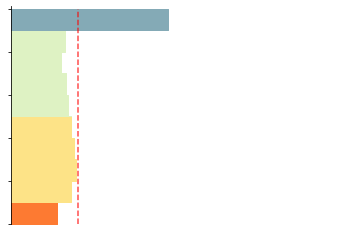

In [16]:
plt.clf()

ax2 = plt.gca()
ax2 = plot_quantile_hist(ax2, macro, df)


plt.show()

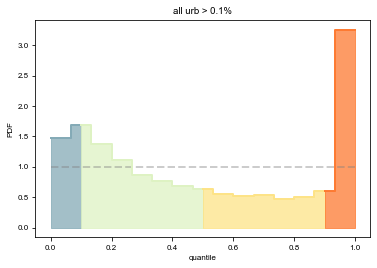

In [17]:
plt.clf()

# bins = np.array([0., 0.1, 0.5, 0.9, 1.0])
bins = 15
alpha = 0.75
min_urb = 0.001

color_blu = 1.*np.array([132,170,182])/255
color_cyan = 1.*np.array([222,242,195])/255
color_yellow = 1.*np.array([253,227,135])/255
color_orange = 1.*np.array([253,122,50])/255
colors = [color_blu, color_cyan, color_yellow, color_orange]

# for macro,df in dfm.groupby('macro'):
# data = dfm.dropna().quant.values
df0 = dfm[dfm.urban_area_km2 / dfm.tile_km2 > min_urb]
data = df0.dropna().quant.values

yy, xx = np.histogram(data, bins=bins, density=True)
yy0 = np.concatenate(([yy[0]],yy))

#     plt.plot(xx, yy0, '--', drawstyle='steps', lw=2)

isplt0 = np.searchsorted(xx, [0.1, 0.5, 0.9])
yy = []
for j,y in enumerate(yy0):
    yy += [y]
    if j in isplt0:
        yy += [y, y]


eps = 0.9999
xx = sorted(list(xx) +  [0.1, 0.5, 0.9] + list(np.array([0.1, 0.5, 0.9])*eps))
isplt = np.searchsorted(xx, [0.1, 0.5, 0.9])
xs = np.split(xx, isplt)
ys = np.split(yy, isplt)
for i,(x,y) in enumerate(zip(xs, ys)):

    p = plt.plot(x, y, '-', drawstyle='steps', alpha=0.99, lw=2, color=colors[i])
    color = p[0].get_color()

    plt.fill_between(x, 0, y, alpha=alpha, color=color, step="pre")

plt.hlines(1., 0., 1., linestyles='--', lw=2, color='grey', alpha=0.4)


plt.title(u"all urb > {}%".format(min_urb*1e2))
plt.xlabel('quantile')
plt.ylabel('PDF')


# plt.savefig('./quantiles_histogram_all.pdf')
plt.show()

# Confidence intervals

In [18]:
np.random.seed(0)

color_blu = 1.*np.array([132,170,182, 255*1])/255
color_cyan = 1.*np.array([222,242,195, 255*1])/255
color_yellow = 1.*np.array([253,227,135, 255*1])/255
color_orange = 1.*np.array([253,122,50, 255*1])/255
    

def get_fig3_color(quantile):
    
    if quantile < 0.1:
        return color_orange
    elif 0.1 <= quantile < 0.5:
        return color_yellow
    elif 0.5 <= quantile < 0.9:
        return color_cyan
    else:
        return color_blu
    
    
    
def compute_urb_quantile(macro, macro2tileid2data, tileid2urb_phase_quantile, verbose=False):
    urb_quantile = []

#     max_tile_area = macro2max_tile_area[macro]

    tileid2data = macro2tileid2data[macro]

    tot = len(tileid2data)
    count = 0 
    for tileid,(urban_area_km2, num_urban, tile_km2) in tileid2data.items():
        if verbose:
            count +=1
            if count % 20 == 0:
                ssw(f' tile {count} of {tot}...             \r'); ssf()

        if tileid not in tileid2urb_phase_quantile:
            continue
            
        if urban_area_km2 > 0. and urban_area_km2 < tile_km2:  # and tile_km2 > alim 
            x = urban_area_km2 / tile_km2
#             x = urban_area_km2 / max_tile_area
            y = tileid2urb_phase_quantile[tileid]
            urb_quantile += [[x,y]]

#     len(urb_quantile)
    return urb_quantile


def plot_CIs_quantiles(ax, urb_quantile, counter=None, title=False):

    df = pd.DataFrame(urb_quantile, columns=['urb', 'quantile']).dropna(subset=['quantile'])
    bins = pd.cut(df['urb'], np.logspace(-7,0, 20))
    groups = df.groupby(bins)
    midpoints = [b.mid for b in groups.groups.keys()]
    
    xmin, xmax = 1e-6, 1e0
    perc = 1e2
    fsz = 20
    
    a = groups['quantile'].quantile(0.1).dropna()
    x1 = np.array([i.mid for i in  a.index.values.tolist()]) * perc
    y1 = a.values
    ax.plot(x1, y1, '-k', lw=0.6, alpha=0.7)

    a = groups['quantile'].quantile(0.5).dropna()
    x5 = np.array([i.mid for i in  a.index.values.tolist()]) * perc
    y5 = a.values
    ax.plot(x5, y5, '--k', lw=1, color='k')

    a = groups['quantile'].quantile(0.9).dropna()
    x9 = np.array([i.mid for i in  a.index.values.tolist()]) * perc
    y9 = a.values
    ax.plot(x9, y9, '-k', lw=0.6, color='k', alpha=0.7)

    ax.fill_between(x1, y9, y1, color='k', alpha=0.2 )

    # perc_10 = groups['quantile'].apply(lambda x: np.percentile(x, 10.)).values
    # perc_50 = groups['quantile'].apply(lambda x: np.percentile(x, 50.)).values
    # perc_90 = groups['quantile'].apply(lambda x: np.percentile(x, 90.)).values

    # plt.plot(midpoints, perc_10, '-k', lw=1)
    # plt.plot(midpoints, perc_50, '--k', lw=1)
    # plt.plot(midpoints, perc_90, '-k', lw=1)

    # plt.fill_between(midpoints, perc_90, perc_10, color='k', alpha=0.25 )

#     x = np.array([midpoints[0], midpoints[-1]]) * perc
    x = np.array([xmin, xmax]) * perc
    ax.fill_between(x, 0.9, 1.01, color=color_blu, zorder=0 )
    ax.fill_between(x, 0.5, 0.9, color=color_cyan, zorder=0 )
    ax.fill_between(x, 0.1, 0.5, color=color_yellow, zorder=0 )
    ax.fill_between(x, 0.0, 0.1, color=color_orange, zorder=0 )
    
    ax.hlines(0.1, x[0], x[1], color='red', linestyle='-', lw=1, zorder=0)
    ax.hlines(0.5, x[0], x[1], color='red', linestyle='--', lw=1, zorder=0)
    ax.hlines(0.9, x[0], x[1], color='red', linestyle='-', lw=1, zorder=0)


    lu = len(urb_quantile)
    ll = min(lu, 1000)
    sample = np.random.choice(lu, ll, replace=False)
    for i in sample:
        x0,y0 = urb_quantile[i]
        ax.plot(x0 * perc, y0, '.', ms=0.99,  color='k')


    # plt.hlines(0.1, xmin=midpoints[0], xmax=midpoints[-1] , lw=1)
    # plt.hlines(0.5, xmin=midpoints[0], xmax=midpoints[-1] , lw=1)
    # plt.hlines(0.9, xmin=midpoints[0], xmax=midpoints[-1] , lw=1)

    ax.set_xlim(x)
    ax.set_ylim(0., 1.01)
    ax.set_xscale('log')

    # plt.legend(frameon=False, loc="best", fontsize=int(fsz*0.7) )#, bbox_to_anchor=(1.75,1), ncol=3)
    if title:
#         plt.title(macro)
        pass
#     plt.xlabel(r'Urb % ($A_{urb} / A_{tile}$)', fontsize=fsz)
#     plt.ylabel(r'$N / A_{tile}$', fontsize=fsz)
    if counter is None or counter > 23:
        ax.set_xlabel(r'Built-up Area %')
    if counter is None or counter % 8 == 0:
        ax.set_ylabel(r'quantile($N$)')

    # plt.show()
    return ax


# Final figure

In [19]:
tileid2urb_phase_quantile_rescaled4 = {row['tileid']: row['quant'] for i, row in dfm.iterrows()}

In [20]:
macro = 'North America'
df = dfm[dfm['macro'] == macro].copy()

urb_quantile = compute_urb_quantile(macro, macro2tileid2data, \
                    tileid2urb_phase_quantile_rescaled4)

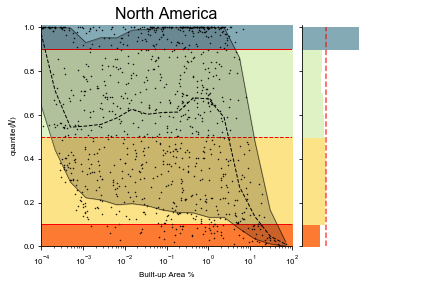

In [21]:
fig = plt.figure(figsize=[6,4])
plt.clf()
plt.tight_layout()

gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.0, right=1., wspace=0.05)

ax = plt.subplot(gs2[:, :-1])
ax = plot_CIs_quantiles(ax, urb_quantile.copy())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = plt.subplot(gs2[:, -1])
ax2 = plot_quantile_hist(ax2, macro, df)
ax.set_title('%s'%macro, fontsize=16)

gs2.tight_layout(fig, w_pad=0.01)


plt.show()

### create figures for all macro areas

<Figure size 432x288 with 0 Axes>

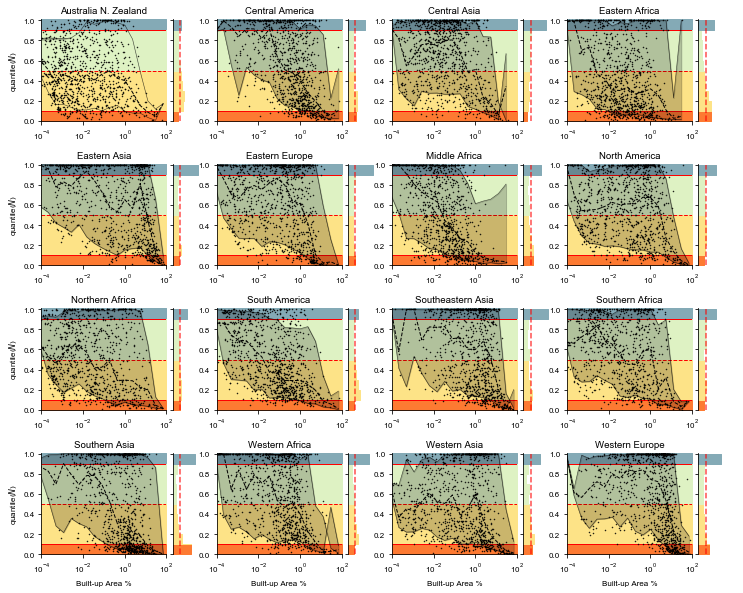

In [22]:
plt.clf()
f, axs = plt.subplots(4, 8, figsize=figsize(1.6, 0.8), sharey=False, gridspec_kw={'width_ratios':[3,0.9 ,3, 0.9, 3, 0.9,3, 0.9]})
axs = axs.flatten()

for (macro, df), i in zip(dfm.groupby('macro'), range(0, 16*2, 2)):
    ax = axs[i]
    
    urb_quantile = compute_urb_quantile(macro, macro2tileid2data.copy(), \
                        tileid2urb_phase_quantile_rescaled4.copy())
    
    ax = plot_CIs_quantiles(ax, urb_quantile.copy(), i)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('%s'%macro)
    _ = plot_quantile_hist(axs[i+1], macro, df)
    

plt.tight_layout()
plt.subplots_adjust(wspace=0.08)
f.savefig('{}/appendix_quantiles.png'.format(fig_dir), bbox_inches='tight', pad_inches=0.05)

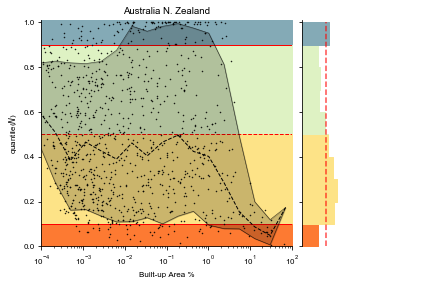

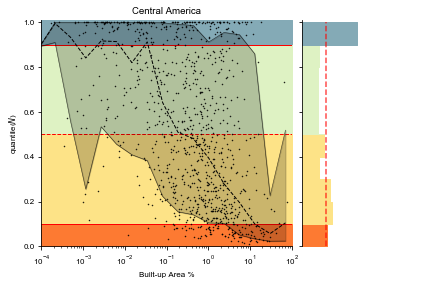

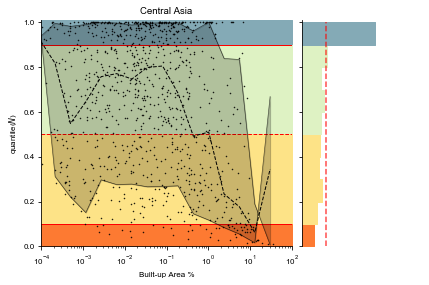

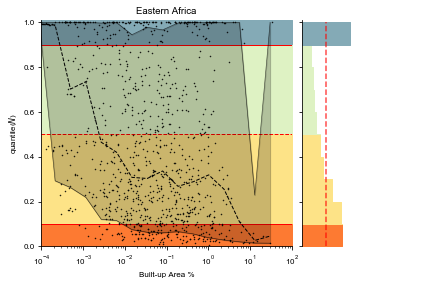

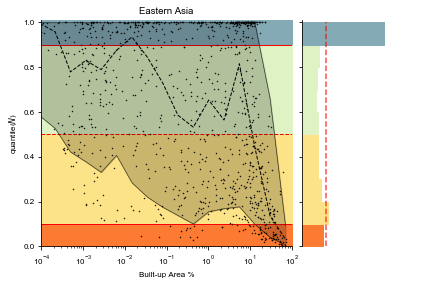

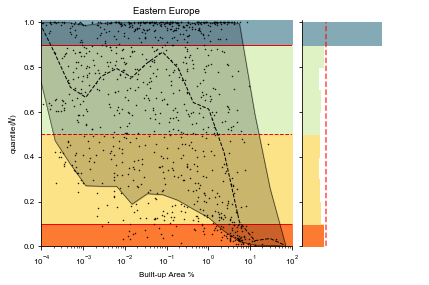

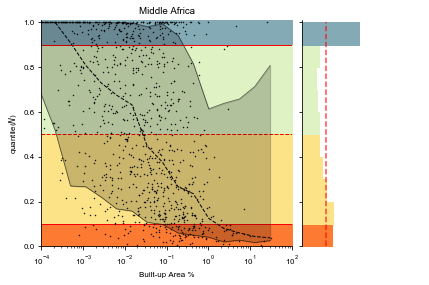

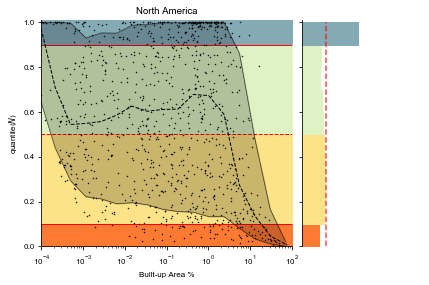

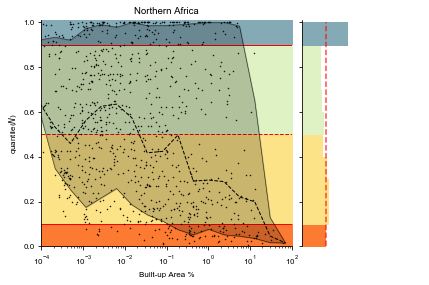

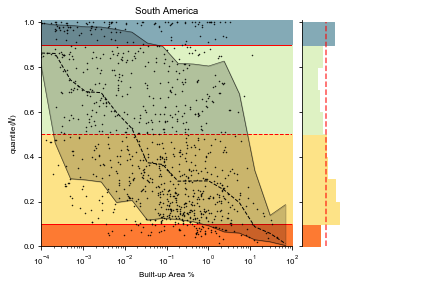

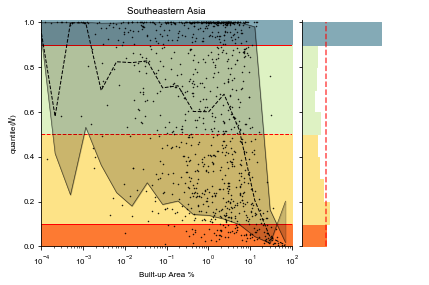

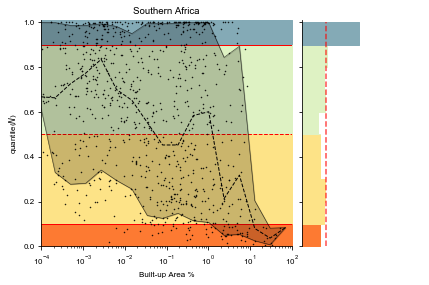

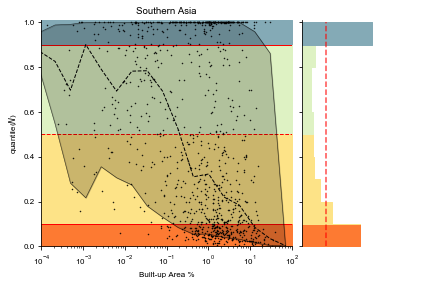

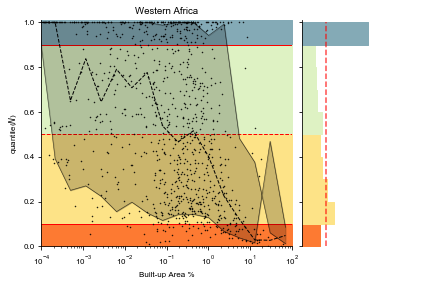

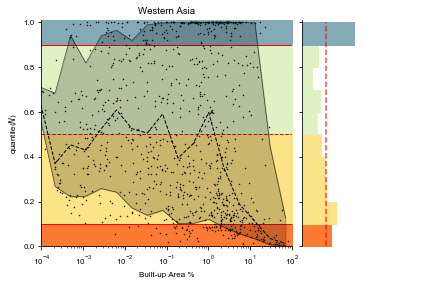

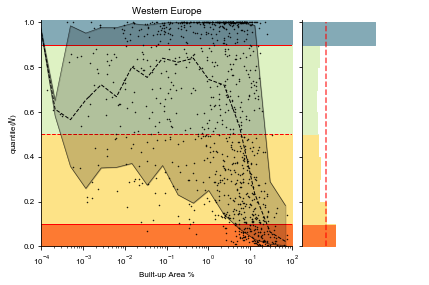

In [23]:
for macro,df in dfm.groupby('macro'):
    
    
    urb_quantile = compute_urb_quantile(macro, macro2tileid2data.copy(), \
                        tileid2urb_phase_quantile_rescaled4.copy())
    
    fig = plt.figure(figsize=[6,4])
    plt.clf()
    plt.tight_layout()
    
    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.0, right=1.0, wspace=0.0)

    ax = plt.subplot(gs2[:, :-1])
    ax = plot_CIs_quantiles(ax, urb_quantile.copy())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('%s'%macro)

    ax2 = plt.subplot(gs2[:, -1])
    ax2 = plot_quantile_hist(ax2, macro, df)

    gs2.tight_layout(fig, w_pad=0.01)
    
    plt.savefig('{}/{}_quantiles_histogram.pdf'.format(fig_dir, macro.replace(' ','_')), bbox_inches='tight', pad_inches=0.05)

# CCDF built-up areas per class

In [24]:
def get_phase(quant):
    bins = np.array([-0.1, 0.1, 0.5, 0.9, 1.0])
    return np.searchsorted(bins, quant)

phase2color = {
    1: color_orange, 2 : color_yellow, 3 : color_cyan, 4 : color_blu
              }

In [25]:
dfm[:3]

,tileid,quant,macro,urban_area_km2,num_urban,tile_km2
0,46588,0.307,South America,0.007575,1.0,183.837976
1,47297,0.544,South America,0.005453,1.0,532.543810
2,48000,0.428,South America,0.017032,6.0,345.254837


In [26]:
dfm['phase'] = dfm['quant'].apply(get_phase)
dfm[:3]

,tileid,quant,macro,urban_area_km2,num_urban,tile_km2,phase
0,46588,0.307,South America,0.007575,1.0,183.837976,2
1,47297,0.544,South America,0.005453,1.0,532.543810,3
2,48000,0.428,South America,0.017032,6.0,345.254837,2


#### substitute class 5 (0/0) with `nan`

In [27]:
dfm[dfm['tileid'] == '51310']

,tileid,quant,macro,urban_area_km2,num_urban,tile_km2,phase
45428,51310,NaN,Australia N. Zealand,0.0,0.0,2.966727,5


In [28]:
dfm.phase.replace(to_replace=[5], value=np.nan, inplace=True)

In [29]:
dfm[dfm['tileid'] == '51310']

,tileid,quant,macro,urban_area_km2,num_urban,tile_km2,phase
45428,51310,NaN,Australia N. Zealand,0.0,0.0,2.966727,NaN


In [30]:
macro2phase2builtup = {m : {} for m in all_macros}

for g, df in dfm.groupby(by=['macro', 'phase']):
    macro, phase = g
    if pd.isna(phase):
        continue
    builtup = (df.urban_area_km2 / df.tile_km2).dropna().values
    macro2phase2builtup[macro][phase] = builtup

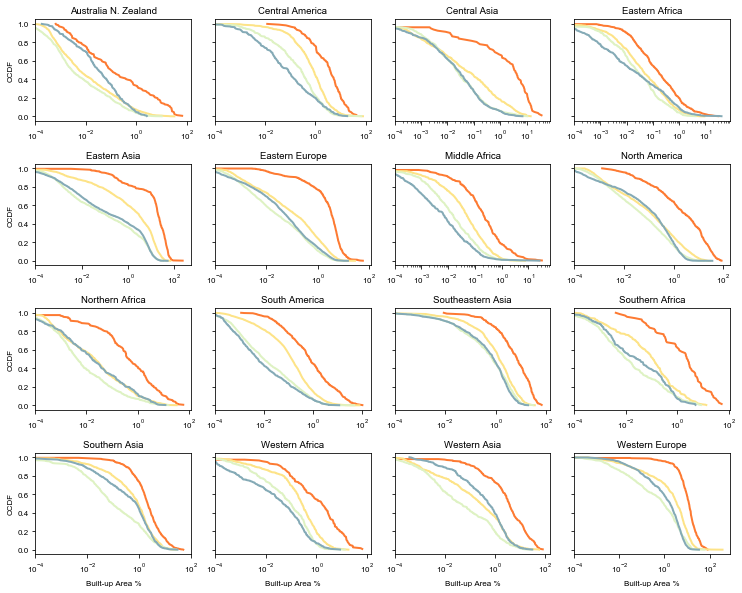

In [31]:
fsz = 20

f, axs = plt.subplots(4, 4, figsize=figsize(1.6, 0.8), sharey=True)
axs = axs.flatten()
counter = 0

for (macro, p2b), ax in zip(macro2phase2builtup.items(), axs):
    
    for p,builtup in p2b.items():
        
        color = phase2color[p]
        x,y = ccdf(builtup * 1e2)
        ax.plot(x, y, '-', color=color, lw=2)

    if counter > 11:
        ax.set_xlabel('Built-up Area %')
    if counter % 4 == 0:
        ax.set_ylabel('CCDF')
    ax.set_xscale('log')
    ax.set_xlim(1e-4, None)
#     plt.yscale('log')
    ax.set_title('%s'%macro)
    counter += 1

plt.tight_layout()
plt.savefig('{}/appendix_ccdfs.png'.format(fig_dir), bbox_inches='tight', pad_inches=0.05)

# CCDF BUC areas (rescaled 4) by macro regions

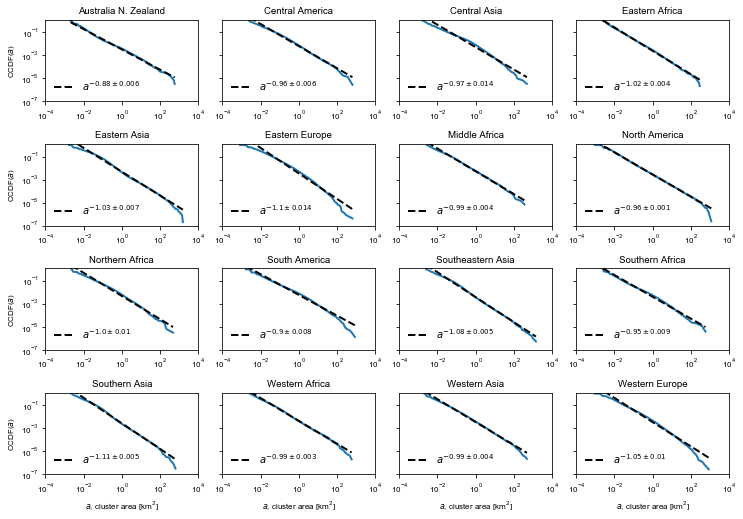

In [32]:
f, axs = plt.subplots(4, 4, figsize=figsize(1.6, 0.7), sharey=True)
axs = axs.flatten()
counter = 0

for macro, ax in zip(macro2tileid.keys(), axs):
    
    x,y,n = macro2ccdf_rescaled4[macro]
    # color = 'b'
    p = ax.plot(x,y,'-', lw=2)#, label=np.round(k,2))
    
    color = 'k'
    B, A, Aerr = power_law_fit_ccdf(x, y, lower_cutoff=1e-2, upper_cutoff=1e2)
    ax.plot(x, B * x ** A, '--', color=color, lw=2, alpha=0.99,\
             label=r'$a^{%s \pm %s}$'%(np.round(A,2),np.round(Aerr,3)) )
    # plt.plot(x, B * x **(A-Aerr), '--r', lw=2, alpha=0.5)
    # plt.plot(x, B * x **(A+Aerr), '--r', lw=2, alpha=0.5)
        

    ax.legend(loc='best', frameon=False, ncol=1, fontsize=fsz*0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e4)
    ax.set_ylim(1e-7, 1.2)
    ax.set_title(macro)
    if counter > 11:
        ax.set_xlabel(r'$a$, cluster area [km$^2$]')
    if counter % 4 == 0:
        ax.set_ylabel(r'CCDF($a$)')
    counter += 1

plt.tight_layout()
plt.savefig('{}/appendix_ccdfs_fit.png'.format(fig_dir), bbox_inches='tight', pad_inches=0.05)